In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
#KFold
#https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
#http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn.metrics import mean_squared_error, make_scorer, confusion_matrix, roc_curve, auc
#http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

plt.style.use('ggplot')

In [2]:
X = pd.read_csv('train_values.csv', index_col='row_id')
y = pd.read_csv('train_labels.csv', index_col='row_id')
df_predict = pd.read_csv('test_values.csv', index_col='row_id')

X['health__air_pollution_particulate_matter']=X['health__air_pollution_particulate_matter'].astype(str)
df_predict['health__air_pollution_particulate_matter']=df_predict['health__air_pollution_particulate_matter'].astype(str)

In [ ]:
#y['heart_disease_mortality_per_100k'] > 280 high

In [ ]:
X = X[[
    'area__rucc',
    'area__urban_influence',
    'econ__economic_typology',
    'health__air_pollution_particulate_matter',
    'yr',
    'demo__pct_adults_less_than_a_high_school_diploma',
    'health__pct_physical_inacticity',
    'health__pct_adult_obesity',
    'health__pct_diabetes',
    'health__pct_low_birthweight',
    'demo__death_rate_per_1k',
    'demo__pct_adults_with_high_school_diploma',
    'demo__pct_adults_bachelors_or_higher',
    'econ__pct_civilian_labor',
    'health__pct_adult_smoking',
    ]]

In [ ]:
df_predict = df_predict[[
    'area__rucc',
    'area__urban_influence',
    'econ__economic_typology',
    'health__air_pollution_particulate_matter',
    'yr',
    'demo__pct_adults_less_than_a_high_school_diploma',
    'health__pct_physical_inacticity',
    'health__pct_adult_obesity',
    'health__pct_diabetes',
    'health__pct_low_birthweight',
    'demo__death_rate_per_1k',
    'demo__pct_adults_with_high_school_diploma',
    'demo__pct_adults_bachelors_or_higher',
    'econ__pct_civilian_labor',
    'health__pct_adult_smoking',
    ]]

### Preview Dataset

In [ ]:
X.head()

In [ ]:
X.describe()

In [ ]:
X.shape

In [ ]:
X.isnull().sum()

In [ ]:
X.dtypes

### Create Correction list and categorical list

In [3]:
def create_list(df, y):
    corr_list = []
    categorical_list = []
    numeric_count = 0
    
    for col in df.columns:
        if np.issubdtype(df[col].dtype, np.number):
            corr = (col, y[y.columns[0]].corr(X[col]))
            #print(col, ": ", corr)
            corr_list.append(corr)
        
            numeric_count += 1
            min_val = df[col].min()
            max_val = df[col].max()
            print(numeric_count, col, '\n Min:', min_val,'Max:', max_val, '\n')
        
        else:
            categorical_list.append(col)
            
    return corr_list, categorical_list

corr_list, X_cat_list = create_list(X, y)

1 econ__pct_civilian_labor 
 Min: 0.207 Max: 1.0 

2 econ__pct_unemployment 
 Min: 0.01 Max: 0.248 

3 econ__pct_uninsured_adults 
 Min: 0.046 Max: 0.496 

4 econ__pct_uninsured_children 
 Min: 0.012 Max: 0.281 

5 demo__pct_female 
 Min: 0.278 Max: 0.573 

6 demo__pct_below_18_years_of_age 
 Min: 0.092 Max: 0.41700000000000004 

7 demo__pct_aged_65_years_and_older 
 Min: 0.045 Max: 0.34600000000000003 

8 demo__pct_hispanic 
 Min: 0.0 Max: 0.932 

9 demo__pct_non_hispanic_african_american 
 Min: 0.0 Max: 0.858 

10 demo__pct_non_hispanic_white 
 Min: 0.053 Max: 0.99 

11 demo__pct_american_indian_or_alaskan_native 
 Min: 0.0 Max: 0.8590000000000001 

12 demo__pct_asian 
 Min: 0.0 Max: 0.341 

13 demo__pct_adults_less_than_a_high_school_diploma 
 Min: 0.01507537688442211 Max: 0.4735264735264735 

14 demo__pct_adults_with_high_school_diploma 
 Min: 0.06532663316582914 Max: 0.5589123867069486 

15 demo__pct_adults_with_some_college 
 Min: 0.10954773869346733 Max: 0.47395301327885603 

16

### Remove columns/ rows and Replace NaN values

In [4]:
#X.drop(['health__homicides_per_100k'], axis=1, inplace=True)

#Require at least 20/33 non-NA values
#X.dropna(thresh=20, inplace=True)

#fill na with group median
#X.fillna(X.median(), inplace=True)
#X.fillna(X.groupby(['area__rucc','health__air_pollution_particulate_matter']).transform('median'), inplace=True)
#fillna again as there are still some nan values
X.fillna(X.groupby('area__rucc').transform('median'), inplace=True)

#X.head()

In [5]:
#df_predict.drop(['health__homicides_per_100k'], axis=1, inplace=True)

#fill na with group median
#df_predict.fillna(df_predict.groupby(['area__rucc','health__air_pollution_particulate_matter']).transform('median'), inplace=True)
df_predict.fillna(df_predict.groupby('area__rucc').transform('median'), inplace=True)

In [ ]:
df_predict.isnull().sum()

### RandomForestClassifier

In [ ]:
y_dummy = y.copy()
y_dummy['class'] = np.where(y_dummy['heart_disease_mortality_per_100k']> 280, 1,0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_dummy['class'].values.ravel(), train_size =0.80, test_size = 0.2, random_state=84)

In [ ]:
model = RandomForestClassifier(n_estimators=12, oob_score=True)
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

In [ ]:
model.score(X_test,y_test)

In [ ]:
TP = 239
TN = 310
FP = 37
FN = 54

#Recall/ TPR = TP/(TP+FN)
FPR = TP/(TP+FN)
#FPR = FP/(TN+FP)
TPR = FP/(TN+FP) 

# This is the ROC curve
plt.plot(FPR,TPR)
plt.show()

In [ ]:
# This is the AUC
auc = np.trapz(TPR,FPR)

### Take log and check min, max for numeric columns, put catergorical column name to cat_list

In [6]:
def data_transform(df):
    count = 0
    for col in df.columns:       
        if np.issubdtype(df[col].dtype, np.number):
            count += 1
            print(count,'.Updating column:',col)
            df[col] = np.log(df[col]+1)
    return df

In [7]:
X = data_transform(X)
df_predict = data_transform(df_predict)

1 .Updating column: econ__pct_civilian_labor
2 .Updating column: econ__pct_unemployment
3 .Updating column: econ__pct_uninsured_adults
4 .Updating column: econ__pct_uninsured_children
5 .Updating column: demo__pct_female
6 .Updating column: demo__pct_below_18_years_of_age
7 .Updating column: demo__pct_aged_65_years_and_older
8 .Updating column: demo__pct_hispanic
9 .Updating column: demo__pct_non_hispanic_african_american
10 .Updating column: demo__pct_non_hispanic_white
11 .Updating column: demo__pct_american_indian_or_alaskan_native
12 .Updating column: demo__pct_asian
13 .Updating column: demo__pct_adults_less_than_a_high_school_diploma
14 .Updating column: demo__pct_adults_with_high_school_diploma
15 .Updating column: demo__pct_adults_with_some_college
16 .Updating column: demo__pct_adults_bachelors_or_higher
17 .Updating column: demo__birth_rate_per_1k
18 .Updating column: demo__death_rate_per_1k
19 .Updating column: health__pct_adult_obesity
20 .Updating column: health__pct_adult

### One Hot, Train_Test Split and Feature Scaling

In [8]:
def one_hot(df, cat_list):
    return pd.get_dummies(df, columns = cat_list)

In [9]:
#get_dummies as Onehot
X = one_hot(X, X_cat_list)
df_predict = one_hot(df_predict, X_cat_list)

In [35]:
#train:Test = 80:20  df[col] = np.log(df[col]+1)
X_train, X_test, y_train, y_test = train_test_split(X, np.log(np.log(y+1)), train_size =0.80, test_size = 0.2, random_state=154)

In [17]:
((np.exp(np.log(y+1))-1) - y).sum()

heart_disease_mortality_per_100k   -8.967049e-12
dtype: float64

In [36]:
#train:Test = 80:20  df[col] = np.log(df[col]+1)
X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), train_size =0.80, test_size = 0.2, random_state=154)

In [37]:
#feature scaling
std_scale = StandardScaler().fit(X_train)

X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

X_predict_std = std_scale.transform(df_predict)

#set cv by K-Fold
kf = KFold(n_splits=30, shuffle=True, random_state=52)

### Baseline Model

In [20]:
##########Baseline case only##########
print('##########Baseline Model##########')
lr = linear_model.LinearRegression()
lr.fit(X_train_std , y_train)

lr_train_scores = cross_val_score(lr, X_train_std, y_train, scoring='neg_mean_squared_error', cv=kf)
lr_test_scores = cross_val_score(lr, X_test_std, y_test, scoring='neg_mean_squared_error', cv=kf)

print('RMSE for Train set: %.2f' % abs(lr_train_scores.mean())**(1/2))
print('RMSE for Test set: %.2f' % abs(lr_test_scores.mean())**(1/2))

##########Baseline Model##########
RMSE for Train set: 0.02
RMSE for Test set: 0.02


In [22]:
#Finding best parameter for model
def find_best_params(model_name, grid_values):
    model = model_name
    grid_search = GridSearchCV(estimator = model, param_grid = grid_values, scoring='neg_mean_squared_error')
    # Fit the grid search to the data
    grid_search.fit(X_train_std, y_train)
    
    grid_search_scores = cross_val_score(grid_search, X_train_std, y_train, cv=kf, scoring='neg_mean_squared_error')

    print('Grid best parameter: ', grid_search.best_params_)
    print('Best score: %.2f' % abs(grid_search.best_score_)**(1/2))
    print("Accuracy: %0.2f (+/- %0.2f)" % (abs(grid_search_scores.mean())**(1/2), grid_search_scores.std() * 2))

### Ridge Regression

In [23]:
grid_values = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 25, 30, 50]}
model_name = linear_model.Ridge()

find_best_params(model_name, grid_values)

Grid best parameter:  {'alpha': 1}
Best score: 0.02
Accuracy: 0.02 (+/- 0.00)


In [24]:
print('##########Ridge Regression Test Set Result##########')

ridge_lr = linear_model.Ridge(alpha=10)
ridge_lr_train_scores = cross_val_score(ridge_lr, X_train_std, y_train, scoring='neg_mean_squared_error', cv=kf)
ridge_lr_test_scores = cross_val_score(ridge_lr, X_test_std, y_test, scoring='neg_mean_squared_error', cv=kf)

print('RMSE for Train set: %.2f' % abs(ridge_lr_train_scores.mean())**(1/2))
print('RMSE for Test set: %.2f' % abs(ridge_lr_test_scores.mean())**(1/2))

##########Ridge Regression Test Set Result##########
RMSE for Train set: 0.02
RMSE for Test set: 0.02


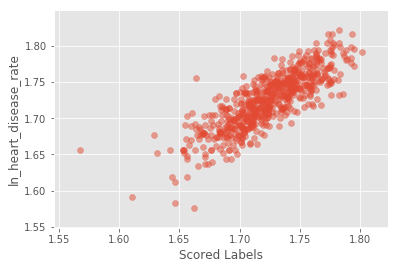

In [33]:
ridge_lr.fit(X_train_std, y_train)
plt.scatter(ridge_lr.predict(X_test_std), y_test['heart_disease_mortality_per_100k'], alpha=0.5)
plt.xlabel('Scored Labels')
plt.ylabel('ln_heart_disease_rate')
plt.show()

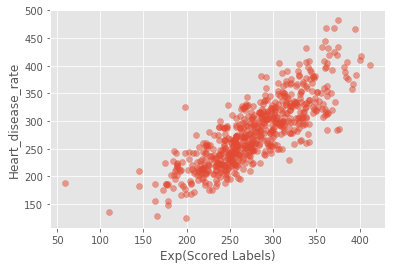

In [46]:
ridge_lr.fit(X_train_std, y_train)
plt.scatter(ridge_lr.predict(X_test_std), y_test, alpha=0.5)
plt.xlabel('Exp(Scored Labels)')
plt.ylabel('Heart_disease_rate')
plt.show()

In [45]:
y_test

array([322, 169, 352, 316, 195, 309, 219, 227, 225, 330, 284, 182, 344,
       354, 267, 260, 404, 149, 304, 236, 326, 199, 256, 276, 248, 303,
       372, 260, 383, 259, 294, 383, 306, 279, 378, 316, 255, 282, 222,
       310, 260, 225, 295, 296, 316, 260, 401, 290, 178, 187, 205, 432,
       335, 346, 214, 337, 325, 328, 203, 198, 265, 214, 250, 304, 300,
       245, 209, 260, 364, 221, 299, 279, 283, 335, 366, 335, 232, 244,
       245, 264, 345, 209, 222, 346, 284, 351, 291, 268, 226, 294, 337,
       273, 176, 325, 350, 221, 466, 304, 288, 273, 360, 233, 349, 255,
       239, 265, 355, 256, 404, 326, 281, 196, 313, 211, 219, 242, 420,
       167, 281, 285, 236, 264, 306, 272, 238, 315, 389, 274, 307, 369,
       285, 234, 308, 230, 287, 265, 235, 482, 229, 299, 155, 259, 289,
       300, 366, 266, 239, 241, 336, 202, 223, 213, 135, 265, 211, 257,
       380, 188, 300, 238, 293, 241, 216, 305, 296, 382, 323, 332, 288,
       187, 257, 297, 343, 210, 261, 319, 353, 246, 375, 434, 27

### Lasso Regression

In [ ]:
"""
print('##########Lasso##########')
lassocv_lr = linear_model.LassoCV()
lassocv_lr.fit(X_train_std , y_train)

#y_cv_lassocv_lr = lassocv_lr.predict(X_cv_std)
#print('RMSE for CV set: %.2f' %(mean_squared_error(y_cv, y_cv_lassocv_lr))** (1/2))

#########After best parameter is selected#########
#y_test_lassocv_lr = lassocv_lr.predict(X_test_std)
#print('RMSE for test set: %.2f' %(mean_squared_error(y_test, y_test_lassocv_lr))** (1/2))

lassocv_lr_scores = cross_val_score(lassocv_lr, X_train, y_train, cv=30, scoring='neg_mean_squared_error')

print('RMSE for Train set: %.2f' % abs(lassocv_lr_scores.mean())**(1/2))
print('RMSE for Test set:')"""

In [25]:
grid_values = {'alpha': [0.01, 0.02, 0.03, 0.05, 0.1, 1, 10], 'max_iter':[10000,5000]}

model_name = linear_model.Lasso()
find_best_params(model_name, grid_values)

Grid best parameter:  {'alpha': 0.01, 'max_iter': 10000}
Best score: 0.03
Accuracy: 0.03 (+/- 0.00)


In [26]:
print('##########Lasso Regression Test Set Result##########')

lasso_lr = linear_model.Lasso(alpha=0.05, max_iter=10000)
lasso_lr_train_scores = cross_val_score(lasso_lr, X_train_std, y_train, scoring='neg_mean_squared_error', cv=kf)
lasso_lr_test_scores = cross_val_score(lasso_lr, X_test_std, y_test, scoring='neg_mean_squared_error', cv=kf)

print('RMSE for Train set: %.2f' % abs(lasso_lr_train_scores.mean())**(1/2))
print('RMSE for Test set: %.2f' % abs(lasso_lr_test_scores.mean())**(1/2))

##########Lasso Regression Test Set Result##########
RMSE for Train set: 0.04
RMSE for Test set: 0.04


### ElasticNet

In [ ]:
grid_values = {'alpha': [0.01, 0.02, 0.03, 0.05, 0.1, 1, 10], 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1]}

model_name = linear_model.ElasticNet()
find_best_params(model_name, grid_values)

In [ ]:
print('##########ElasticNet Test Set Result##########')

en = linear_model.ElasticNet(alpha=0.02, l1_ratio=0.9)
en_train_scores = cross_val_score(en, X_train_std, y_train, scoring='neg_mean_squared_error', cv=kf)
en_test_scores = cross_val_score(en, X_test_std, y_test, scoring='neg_mean_squared_error', cv=kf)

print('RMSE for Train set: %.2f' % abs(en_train_scores.mean())**(1/2))
print('RMSE for Test set: %.2f' % abs(en_test_scores.mean())**(1/2))

### Prediction

In [ ]:
def prediction(model):
    
    #create dataframe for answer
    df = pd.DataFrame(df_predict.index)

    model.fit(X_train_std, y_train)

    #return the result of predict
    df['heart_disease_mortality_per_100k'] = pd.Series(model.predict(X_predict_std))
    df['heart_disease_mortality_per_100k'] =df['heart_disease_mortality_per_100k'].astype('int')
    
    return df

In [ ]:
#df = prediction(linear_model.Ridge(alpha=10)) #32.1999
df = prediction(linear_model.Lasso(alpha=0.05, max_iter=10000)) #32.1632 #32.1086 by group median
#df = prediction(linear_model.LinearRegression()) #32.2258
#df = prediction(RandomForestRegressor(bootstrap=True, max_depth=25, max_features=20, min_samples_leaf=3, min_samples_split=3)) #35.7147

df.to_csv('test_labels.csv', index=False)

### Random Forest

In [ ]:
grid_values = {
    'bootstrap': [True],
    'max_depth': [15, 20, 25],
    'max_features': [10, 15, 20],
    'min_samples_leaf': [3, 5, 8],
    'min_samples_split': [3, 5, 8],
}
model_name = RandomForestRegressor()
find_best_params(model_name, grid_values)

In [ ]:
#n_estimators, max_features, max_depth, min_samples_split 
#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
print('##########Random Forest Test Set Result##########')

rf = RandomForestRegressor(bootstrap=True, max_depth=15, max_features=20, min_samples_leaf=3, min_samples_split=3)
rf_train_scores = cross_val_score(rf, X_train_std, y_train, scoring='neg_mean_squared_error', cv=kf)
rf_test_scores = cross_val_score(rf, X_test_std, y_test, scoring='neg_mean_squared_error', cv=kf)

print('RMSE for Train set: %.2f' % abs(rf_train_scores.mean())**(1/2))
print('RMSE for Test set: %.2f' % abs(rf_test_scores.mean())**(1/2))

### Feature Importances

In [ ]:
rf.fit(X_train_std, y_train)
df_feature = pd.DataFrame(X.columns, columns=['feature'])

#return the result of predict
df_feature['feature_importances'] = pd.Series(rf.feature_importances_)

In [ ]:
#feature_importances of catergorical features
cat_list = ['area__rucc', 'area__urban_influence', 'econ__economic_typology', 'health__air_pollution_particulate_matter', 'yr']
df_feature[df_feature['feature'].isin(cat_list)]

In [ ]:
#Top 10 features
df_feature.sort_values(by=['feature_importances'], ascending=False).head(10)

### Others

In [ ]:
#https://stackoverflow.com/questions/42228735/scikit-learn-gridsearchcv-with-multiple-repetitions/42230764#42230764
#https://stackoverflow.com/questions/42362027/model-help-using-scikit-learn-when-using-gridsearch/42364900#42364900
kf = KFold(n_splits=5, shuffle=True, random_state=52)
gcv = GridSearchCV(pipe, param_grid = grid_values, cv=cv)

gcv.fit(features,labels) #with the full dataset

for train_ind, test_ind in cv.split(features,labels):
    x_train, x_test = features[train_ind], features[test_ind]
    y_train, y_test = labels[train_ind],labels[test_ind]

    gcv.best_estimator_.fit(x_train,y_train)
    gcv.best_estimator_.predict(x_test)
#################################################################    
for train_index, test_index in kf.split(X):
...    print("TRAIN:", train_index, "TEST:", test_index)
...    X_train, X_test = X[train_index], X[test_index]
...    y_train, y_test = y[train_index], y[test_index]
TRAIN: [2 3] TEST: [0 1]
TRAIN: [0 1] TEST: [2 3]

In [ ]:
kf = KFold(n_splits=30, shuffle=True, random_state=52)
for train_index, test_index in kf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [ ]:
##############Test#################
#std_scale = StandardScaler().fit(X)

grid_values = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

cv = KFold(n_splits=10, shuffle=True, random_state=52)
gcv = GridSearchCV(ridge_lr, param_grid = grid_values, cv=cv)

#gcv.fit(features,labels) #with the full dataset
gcv.fit(X, y)

for train_ind, test_ind in cv.split(X, y):
    x_train, x_test = X[train_ind], X[test_ind]
    y_train, y_test = y[train_ind],y[test_ind]

    gcv.best_estimator_.fit(x_train,y_train)
    gcv.best_estimator_.predict(x_test)